In [91]:
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import pylab as pl

## Download and load genetic data

In [56]:
# load genetic data
bfile = '../data/ALL.chr22_GRCh38.genotypes.20170504'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.48it/s]


In [57]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

In [58]:
def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [59]:
# subset to 1000 individuals
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N])
fams, Gs = subset_individuals(fam, G, idxs)

In [60]:
# extract region
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [61]:
# load genotype matrix
X = Gr.compute().T

## Simulate pheno, perform local GWAS and compare groundtruth with GWAS results

In [152]:
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    assert len(idx_caus)==len(var_expl)
    
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus))>0.5) - 1.
    assert len(idx_caus)==len(direction)
    
    # generate phenotype
    ve = 1 - var_expl.sum()
    assert ve>0, 'sum(var_expl) should be < 1'
    beta = np.sqrt(var_expl) * direction
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)
    yg = Xc.dot(beta)[:, None]
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)
    y =  yg + yn
    
    # define beta real
    beta_real = np.zeros(X.shape[1])
    beta_real[idx_caus] = beta
    
    # standardize y and renormalize beta_real accordingly
    ystd = y.std()
    y = (y - y.mean()) / ystd
    beta_real = beta_real / ystd
    
    return y, beta_real

In [153]:
# generate phenotype
n_causal = 1
idx_caus = np.random.choice(X.shape[1], size=n_causal)
var_expl = np.array([0.05])
y, beta_real = simulate_pheno(X, idx_caus, var_expl)

In [154]:
# perform genetic association testing 
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

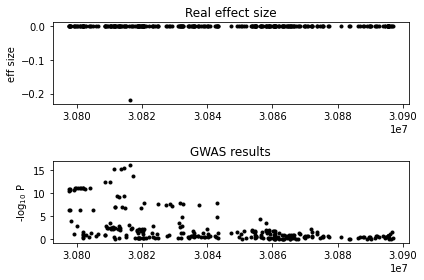

In [155]:
# plot ground truth and results
x = bimr['pos'].values
pl.subplot(211)
pl.title('Real effect size')
pl.plot(x, beta_real, '.k')
pl.ylabel('eff size')
pl.subplot(212)
pl.title('GWAS results')
pl.plot(x, -np.log10(pv), '.k')
pl.ylabel('-log$_{10}$ P')
pl.tight_layout()

## Perform conditional analysis